In [3]:
pip install scikit-optimize

In [4]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install xgboost

In [6]:
import pandas as pd
import gc
import sys
import gc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
import catboost
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor ,ExtraTreesRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.feature_selection import f_regression, SelectKBest
from skopt import BayesSearchCV

IMPORTING DATA FROM CSV FILE

In [7]:
df = pd.read_csv("Scraped_dataset.csv", parse_dates= ["Date of Journey","Date of Booking"])

C:\Users\rvcha\AppData\Local\Temp\ipykernel_24240\3581606920.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("Scraped_dataset.csv", parse_dates= ["Date of Journey","Date of Booking"])
C:\Users\rvcha\AppData\Local\Temp\ipykernel_24240\3581606920.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("Scraped_dataset.csv", parse_dates= ["Date of Journey","Date of Booking"])


EDA ON DATA

In [8]:
df.shape

(452088, 8)

In [9]:
df.dtypes

Date of Booking    datetime64[ns]
Date of Journey    datetime64[ns]
Airline-Class              object
Departure Time             object
Arrival Time               object
Duration                   object
Total Stops                object
Price                      object
dtype: object

CHECKING FOR NULL VALUES

In [10]:
df.isna().sum()

Date of Booking    0
Date of Journey    0
Airline-Class      0
Departure Time     0
Arrival Time       0
Duration           0
Total Stops        0
Price              0
dtype: int64

In [11]:
df.head()

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,2023-01-15,2023-01-16,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335"
1,2023-01-15,2023-01-16,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899"
2,2023-01-15,2023-01-16,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801"
3,2023-01-15,2023-01-16,SpiceJet \nSG-8709\nECONOMY,18:50\nDelhi,20:55\nMumbai,02h 05m,non-stop,"5,794"
4,2023-01-15,2023-01-16,Air India \nAI-805\nECONOMY,20:00\nDelhi,22:10\nMumbai,02h 10m,non-stop,"5,955"


PREPROCESSING AND CLEANING DATA

In [12]:
df['airline'] = df['Airline-Class'].str.split("\n").str[0]

In [13]:
df['class'] = df['Airline-Class'].str.split("\n").str[-1]
df['flight_code'] = df['Airline-Class'].str.split("\n").str[1]

In [14]:
df['source'] = df['Departure Time'].str.split("\n").str[1]

In [15]:
df['Destination'] = df['Arrival Time'].str.split("\n").str[1]

In [16]:
#function for converting time of format "02h 05m" to minutes
def convert_to_minutes(time_taken):

    t = time_taken[:-1].split('h ')
    total_minutes = int(t[0]) * 60 + int(t[1])
    return total_minutes
df['Duration_min'] = df['Duration'].apply(convert_to_minutes)


In [17]:
#function for converting time of format 00:00 to minutes
def convert_to_minute(time_taken):

    t = time_taken.split('\n')
    t_split=t[0].split(':')
    total_minutes = int(t_split[0]) * 60 + int(t_split[1])
    return total_minutes


In [18]:
df['dept_time'] = df['Departure Time'].apply(convert_to_minute)
df['arr_time'] = df['Arrival Time'].apply(convert_to_minute)

In [19]:
df.head()

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price,airline,class,flight_code,source,Destination,Duration_min,dept_time,arr_time
0,2023-01-15,2023-01-16,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335",SpiceJet,ECONOMY,SG-8169,Delhi,Mumbai,125,1200,1325
1,2023-01-15,2023-01-16,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899",Indigo,ECONOMY,6E-2519,Delhi,Mumbai,140,1380,80
2,2023-01-15,2023-01-16,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801",GO FIRST,ECONOMY,G8- 354,Delhi,Mumbai,130,1350,40
3,2023-01-15,2023-01-16,SpiceJet \nSG-8709\nECONOMY,18:50\nDelhi,20:55\nMumbai,02h 05m,non-stop,"5,794",SpiceJet,ECONOMY,SG-8709,Delhi,Mumbai,125,1130,1255
4,2023-01-15,2023-01-16,Air India \nAI-805\nECONOMY,20:00\nDelhi,22:10\nMumbai,02h 10m,non-stop,"5,955",Air India,ECONOMY,AI-805,Delhi,Mumbai,130,1200,1330


In [20]:
df.drop(["Duration","Airline-Class","Arrival Time","Departure Time"],axis=1,inplace=True)

In [21]:
df.head()

,Date of Booking,Date of Journey,Total Stops,Price,airline,class,flight_code,source,Destination,Duration_min,dept_time,arr_time
0,2023-01-15,2023-01-16,non-stop,"5,335",SpiceJet,ECONOMY,SG-8169,Delhi,Mumbai,125,1200,1325
1,2023-01-15,2023-01-16,non-stop,"5,899",Indigo,ECONOMY,6E-2519,Delhi,Mumbai,140,1380,80
2,2023-01-15,2023-01-16,non-stop,"5,801",GO FIRST,ECONOMY,G8- 354,Delhi,Mumbai,130,1350,40
3,2023-01-15,2023-01-16,non-stop,"5,794",SpiceJet,ECONOMY,SG-8709,Delhi,Mumbai,125,1130,1255
4,2023-01-15,2023-01-16,non-stop,"5,955",Air India,ECONOMY,AI-805,Delhi,Mumbai,130,1200,1330


In [22]:
df["price"] = df["Price"].apply(lambda x: int(x.replace(',', '')))

In [23]:
df['Total Stops'].unique()

array(['non-stop', '1-stop', '2+-stop',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Indore',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia DIB',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Guwahati',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia VTZ',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia RPR',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Mumbai',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Delhi',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Pune',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia PNQ'], dtype=object)

In [24]:
#funtion for labeling stops column 
def label_encode(stop_value):
    if "1-stop" in stop_value:
        return 1
    elif "2+-stop" in stop_value:
        return 2
    else:
        return 0

df["stops"] = df["Total Stops"].apply(label_encode)

In [25]:
df['days_left'] = (df['Date of Journey'] - df['Date of Booking']).dt.days
df["Date of Journey"] = df["Date of Journey"].dt.strftime("%Y-%d-%m")
df["Date of Journey"] = pd.to_datetime(df["Date of Journey"],format="%Y-%d-%m")
df["month"] = df["Date of Journey"].dt.month
df["day"] = df["Date of Journey"].dt.day

In [26]:
df['Destination'].unique()

array(['Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai',
       'Ahmedabad', 'Delhi'], dtype=object)

In [27]:
df['source'].unique()

array(['Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai',
       'Ahmedabad'], dtype=object)

In [28]:
df.head()

,Date of Booking,Date of Journey,Total Stops,Price,airline,class,flight_code,source,Destination,Duration_min,dept_time,arr_time,price,stops,days_left,month,day
0,2023-01-15,2023-01-16,non-stop,"5,335",SpiceJet,ECONOMY,SG-8169,Delhi,Mumbai,125,1200,1325,5335,0,1,1,16
1,2023-01-15,2023-01-16,non-stop,"5,899",Indigo,ECONOMY,6E-2519,Delhi,Mumbai,140,1380,80,5899,0,1,1,16
2,2023-01-15,2023-01-16,non-stop,"5,801",GO FIRST,ECONOMY,G8- 354,Delhi,Mumbai,130,1350,40,5801,0,1,1,16
3,2023-01-15,2023-01-16,non-stop,"5,794",SpiceJet,ECONOMY,SG-8709,Delhi,Mumbai,125,1130,1255,5794,0,1,1,16
4,2023-01-15,2023-01-16,non-stop,"5,955",Air India,ECONOMY,AI-805,Delhi,Mumbai,130,1200,1330,5955,0,1,1,16


In [29]:
df.drop(["Price","Total Stops","Date of Journey","Date of Booking","flight_code"],axis=1,inplace=True)

In [30]:
df.head()

,airline,class,source,Destination,Duration_min,dept_time,arr_time,price,stops,days_left,month,day
0,SpiceJet,ECONOMY,Delhi,Mumbai,125,1200,1325,5335,0,1,1,16
1,Indigo,ECONOMY,Delhi,Mumbai,140,1380,80,5899,0,1,1,16
2,GO FIRST,ECONOMY,Delhi,Mumbai,130,1350,40,5801,0,1,1,16
3,SpiceJet,ECONOMY,Delhi,Mumbai,125,1130,1255,5794,0,1,1,16
4,Air India,ECONOMY,Delhi,Mumbai,130,1200,1330,5955,0,1,1,16


VISUALIZATION OF DATA

From which destination peoples are travelling most?

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Mumbai'),
  Text(1, 0, 'Delhi'),
  Text(2, 0, 'Bangalore'),
  Text(3, 0, 'Hyderabad'),
  Text(4, 0, 'Chennai'),
  Text(5, 0, 'Kolkata'),
  Text(6, 0, 'Ahmedabad')])

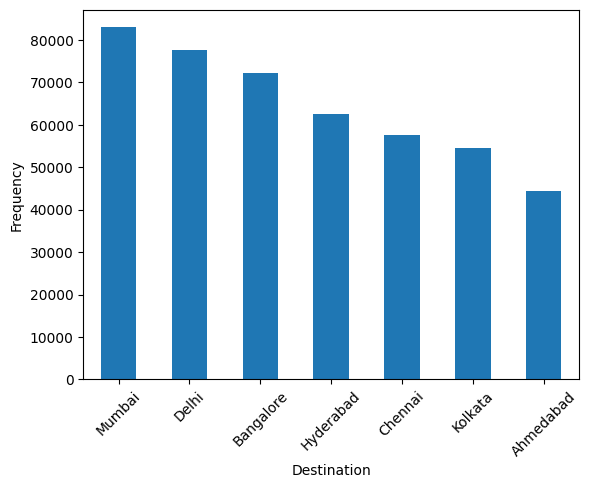

In [31]:
freq=df.Destination.value_counts()
sorted_freq = freq.sort_values(ascending=False)
sorted_freq.plot.bar()
plt.ylabel('Frequency')
plt.xticks(rotation=45)

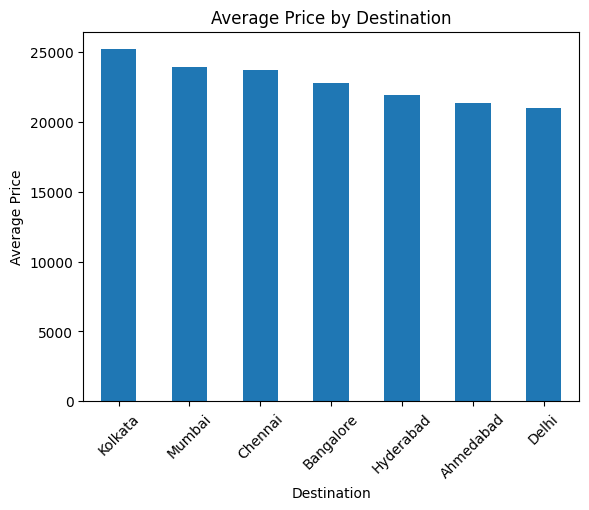

In [32]:
avg_prices = df.groupby("Destination")['price'].mean()
sorted_avg_prices = avg_prices.sort_values(ascending=False)
sorted_avg_prices.plot.bar()

plt.title('Average Price by Destination')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

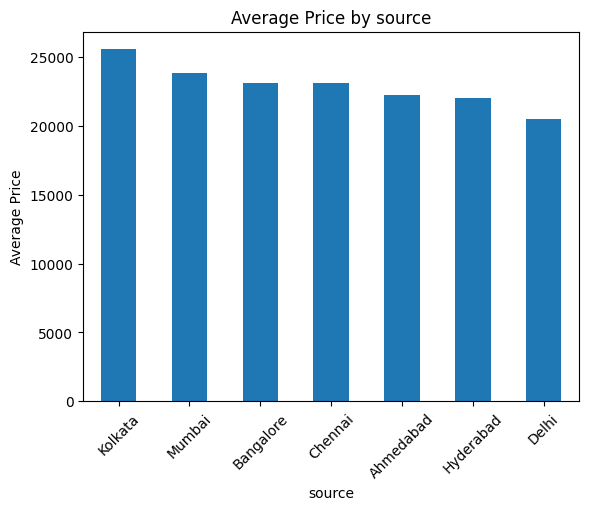

In [33]:
avg_prices = df.groupby("source")['price'].mean()
sorted_avg_prices = avg_prices.sort_values(ascending=False)
sorted_avg_prices.plot.bar()
plt.title('Average Price by source')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

which airline is low budget

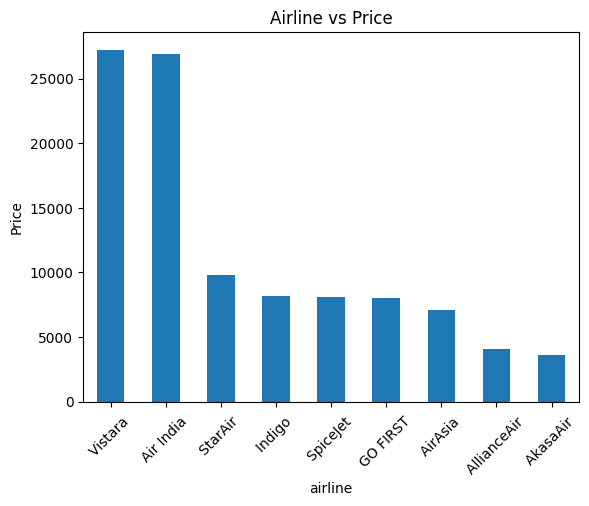

In [34]:
airline_price=df.groupby("airline")['price'].mean()
airline_price = airline_price.sort_values(ascending=False)
airline_price.plot.bar()
plt.title('Airline vs Price')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

Airlinewise passenger count

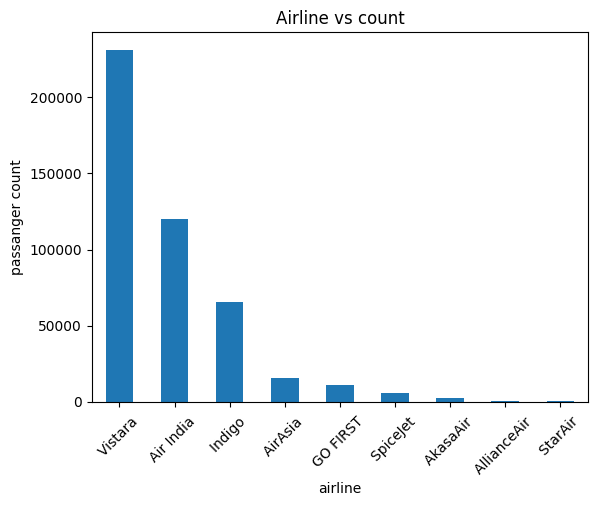

In [35]:
airline_passenger_count = df.airline.value_counts()
airline_passenger_count = airline_passenger_count.sort_values(ascending=False)
airline_passenger_count.plot.bar()
plt.title('Airline vs count')
plt.ylabel('passanger count')
plt.xticks(rotation=45)
plt.show()

Stop Wise Price

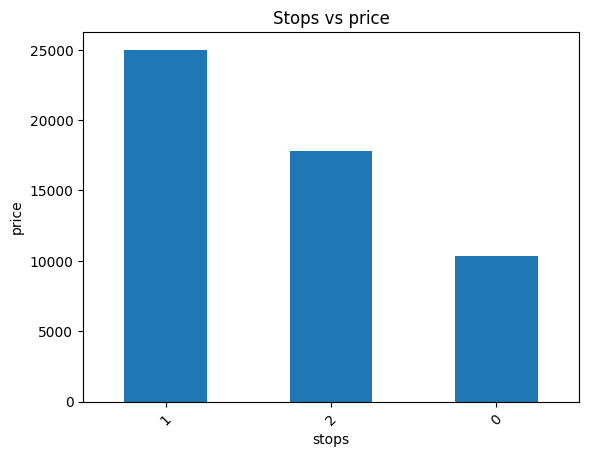

In [36]:
stops = df.groupby("stops")['price'].mean()
stops = stops.sort_values(ascending=False)
stops.plot.bar()
plt.title('Stops vs price')
plt.ylabel('price')
plt.xticks(rotation=45)
plt.show()

Price change in ticket untill last booking day

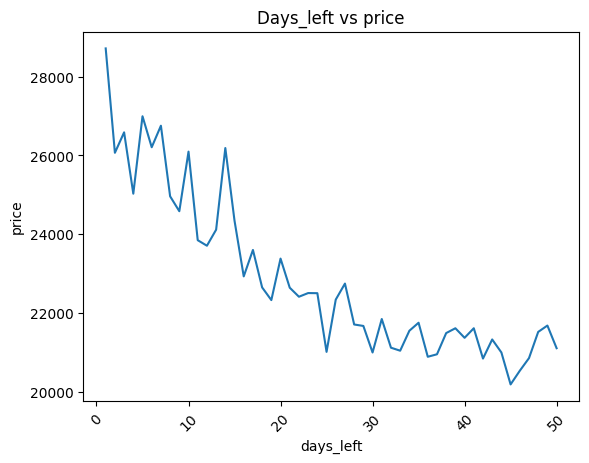

In [37]:
df.groupby("days_left")['price'].mean().plot()

plt.title('Days_left vs price')
plt.ylabel('price')
plt.xticks(rotation=45)
plt.show()

Classwise flight price

c:\Users\rvcha\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rvcha\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Axes: xlabel='class', ylabel='price'>

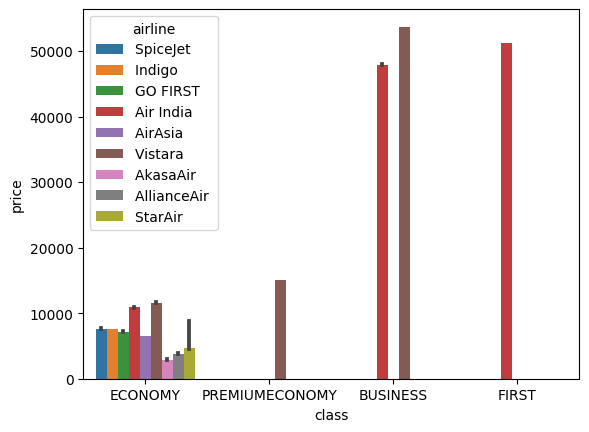

In [38]:
sns.barplot(x = "class", y ="price",  data = df, estimator = np.median, hue = "airline")

In [39]:
df.dtypes


airline         object
class           object
source          object
Destination     object
Duration_min     int64
dept_time        int64
arr_time         int64
price            int64
stops            int64
days_left        int64
month            int32
day              int32
dtype: object

onehot encoding


In [40]:
df_new=df

In [41]:
cat_cols = [ col for col in df_new.columns if df_new[col].dtype=='O']
print(cat_cols)

['airline', 'class', 'source', 'Destination']


In [42]:
#automated code for encoding data
for col in cat_cols:
    encoded_cols = pd.get_dummies(df_new[col], prefix=col, drop_first=True, dtype=int)
    df_new = pd.concat([df_new, encoded_cols], axis=1)
    df_new.drop(col, axis=1, inplace=True)
    
df_new.head()

,Duration_min,dept_time,arr_time,price,stops,days_left,month,day,airline_AirAsia,airline_AkasaAir,...,source_Delhi,source_Hyderabad,source_Kolkata,source_Mumbai,Destination_Bangalore,Destination_Chennai,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_Mumbai
0,125,1200,1325,5335,0,1,1,16,0,0,...,1,0,0,0,0,0,0,0,0,1
1,140,1380,80,5899,0,1,1,16,0,0,...,1,0,0,0,0,0,0,0,0,1
2,130,1350,40,5801,0,1,1,16,0,0,...,1,0,0,0,0,0,0,0,0,1
3,125,1130,1255,5794,0,1,1,16,0,0,...,1,0,0,0,0,0,0,0,0,1
4,130,1200,1330,5955,0,1,1,16,0,0,...,1,0,0,0,0,0,0,0,0,1


In [43]:
df_new.dtypes


Duration_min             int64
dept_time                int64
arr_time                 int64
price                    int64
stops                    int64
days_left                int64
month                    int32
day                      int32
airline_AirAsia          int32
airline_AkasaAir         int32
airline_AllianceAir      int32
airline_GO FIRST         int32
airline_Indigo           int32
airline_SpiceJet         int32
airline_StarAir          int32
airline_Vistara          int32
class_ECONOMY            int32
class_FIRST              int32
class_PREMIUMECONOMY     int32
source_Bangalore         int32
source_Chennai           int32
source_Delhi             int32
source_Hyderabad         int32
source_Kolkata           int32
source_Mumbai            int32
Destination_Bangalore    int32
Destination_Chennai      int32
Destination_Delhi        int32
Destination_Hyderabad    int32
Destination_Kolkata      int32
Destination_Mumbai       int32
dtype: object

In [44]:
df_new.columns

Index(['Duration_min', 'dept_time', 'arr_time', 'price', 'stops', 'days_left',
       'month', 'day', 'airline_AirAsia ', 'airline_AkasaAir ',
       'airline_AllianceAir ', 'airline_GO FIRST ', 'airline_Indigo ',
       'airline_SpiceJet ', 'airline_StarAir ', 'airline_Vistara ',
       'class_ECONOMY', 'class_FIRST', 'class_PREMIUMECONOMY',
       'source_Bangalore', 'source_Chennai', 'source_Delhi',
       'source_Hyderabad', 'source_Kolkata', 'source_Mumbai',
       'Destination_Bangalore', 'Destination_Chennai', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_Mumbai'],
      dtype='object')

In [45]:
df_new.to_csv('prepro_dataset1.csv', index=False)


In [46]:
df_new.head()

,Duration_min,dept_time,arr_time,price,stops,days_left,month,day,airline_AirAsia,airline_AkasaAir,...,source_Delhi,source_Hyderabad,source_Kolkata,source_Mumbai,Destination_Bangalore,Destination_Chennai,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_Mumbai
0,125,1200,1325,5335,0,1,1,16,0,0,...,1,0,0,0,0,0,0,0,0,1
1,140,1380,80,5899,0,1,1,16,0,0,...,1,0,0,0,0,0,0,0,0,1
2,130,1350,40,5801,0,1,1,16,0,0,...,1,0,0,0,0,0,0,0,0,1
3,125,1130,1255,5794,0,1,1,16,0,0,...,1,0,0,0,0,0,0,0,0,1
4,130,1200,1330,5955,0,1,1,16,0,0,...,1,0,0,0,0,0,0,0,0,1


SPLIT DATA IN X AND Y

In [47]:
X = df_new.drop('price', axis=1)
Y = df_new['price']

FEATURE SELECTION 
1. Correlation heatmap
2. Feature Importance
3. SelectKbest

1. Correlation Heatmap

In [48]:
corr = X.corr()
corr.head()

,Duration_min,dept_time,arr_time,stops,days_left,month,day,airline_AirAsia,airline_AkasaAir,airline_AllianceAir,...,source_Delhi,source_Hyderabad,source_Kolkata,source_Mumbai,Destination_Bangalore,Destination_Chennai,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_Mumbai
Duration_min,1.000000,0.122167,-0.012184,0.496742,-0.032878,-0.033490,0.018263,-0.087402,-0.101475,-0.041352,...,-0.061190,0.010712,0.056347,-0.051770,-0.017505,0.043817,-0.083637,0.027803,0.059126,-0.050540
dept_time,0.122167,1.000000,-0.127156,-0.055132,-0.010306,-0.010475,0.006102,-0.003368,0.000953,0.002291,...,0.042225,-0.014217,0.030328,0.001253,-0.000111,0.020870,-0.032676,0.019561,0.011263,-0.022596
arr_time,-0.012184,-0.127156,1.000000,0.050942,0.010944,0.010825,-0.005535,-0.067897,-0.006451,0.002776,...,-0.017217,0.012335,-0.003528,0.032926,0.000526,0.018630,-0.043810,-0.048753,0.023344,0.017980
stops,0.496742,-0.055132,0.050942,1.000000,0.004861,0.001633,0.003955,0.021497,-0.158138,-0.048923,...,-0.045411,0.014461,0.053404,0.002987,-0.035605,0.021683,-0.090794,0.014912,0.045260,-0.003198
days_left,-0.032878,-0.010306,0.010944,0.004861,1.000000,0.883099,-0.263019,-0.002235,-0.000550,-0.000702,...,0.003498,-0.011847,-0.002017,-0.007212,-0.003648,0.007693,-0.023277,0.014754,-0.004832,0.011330


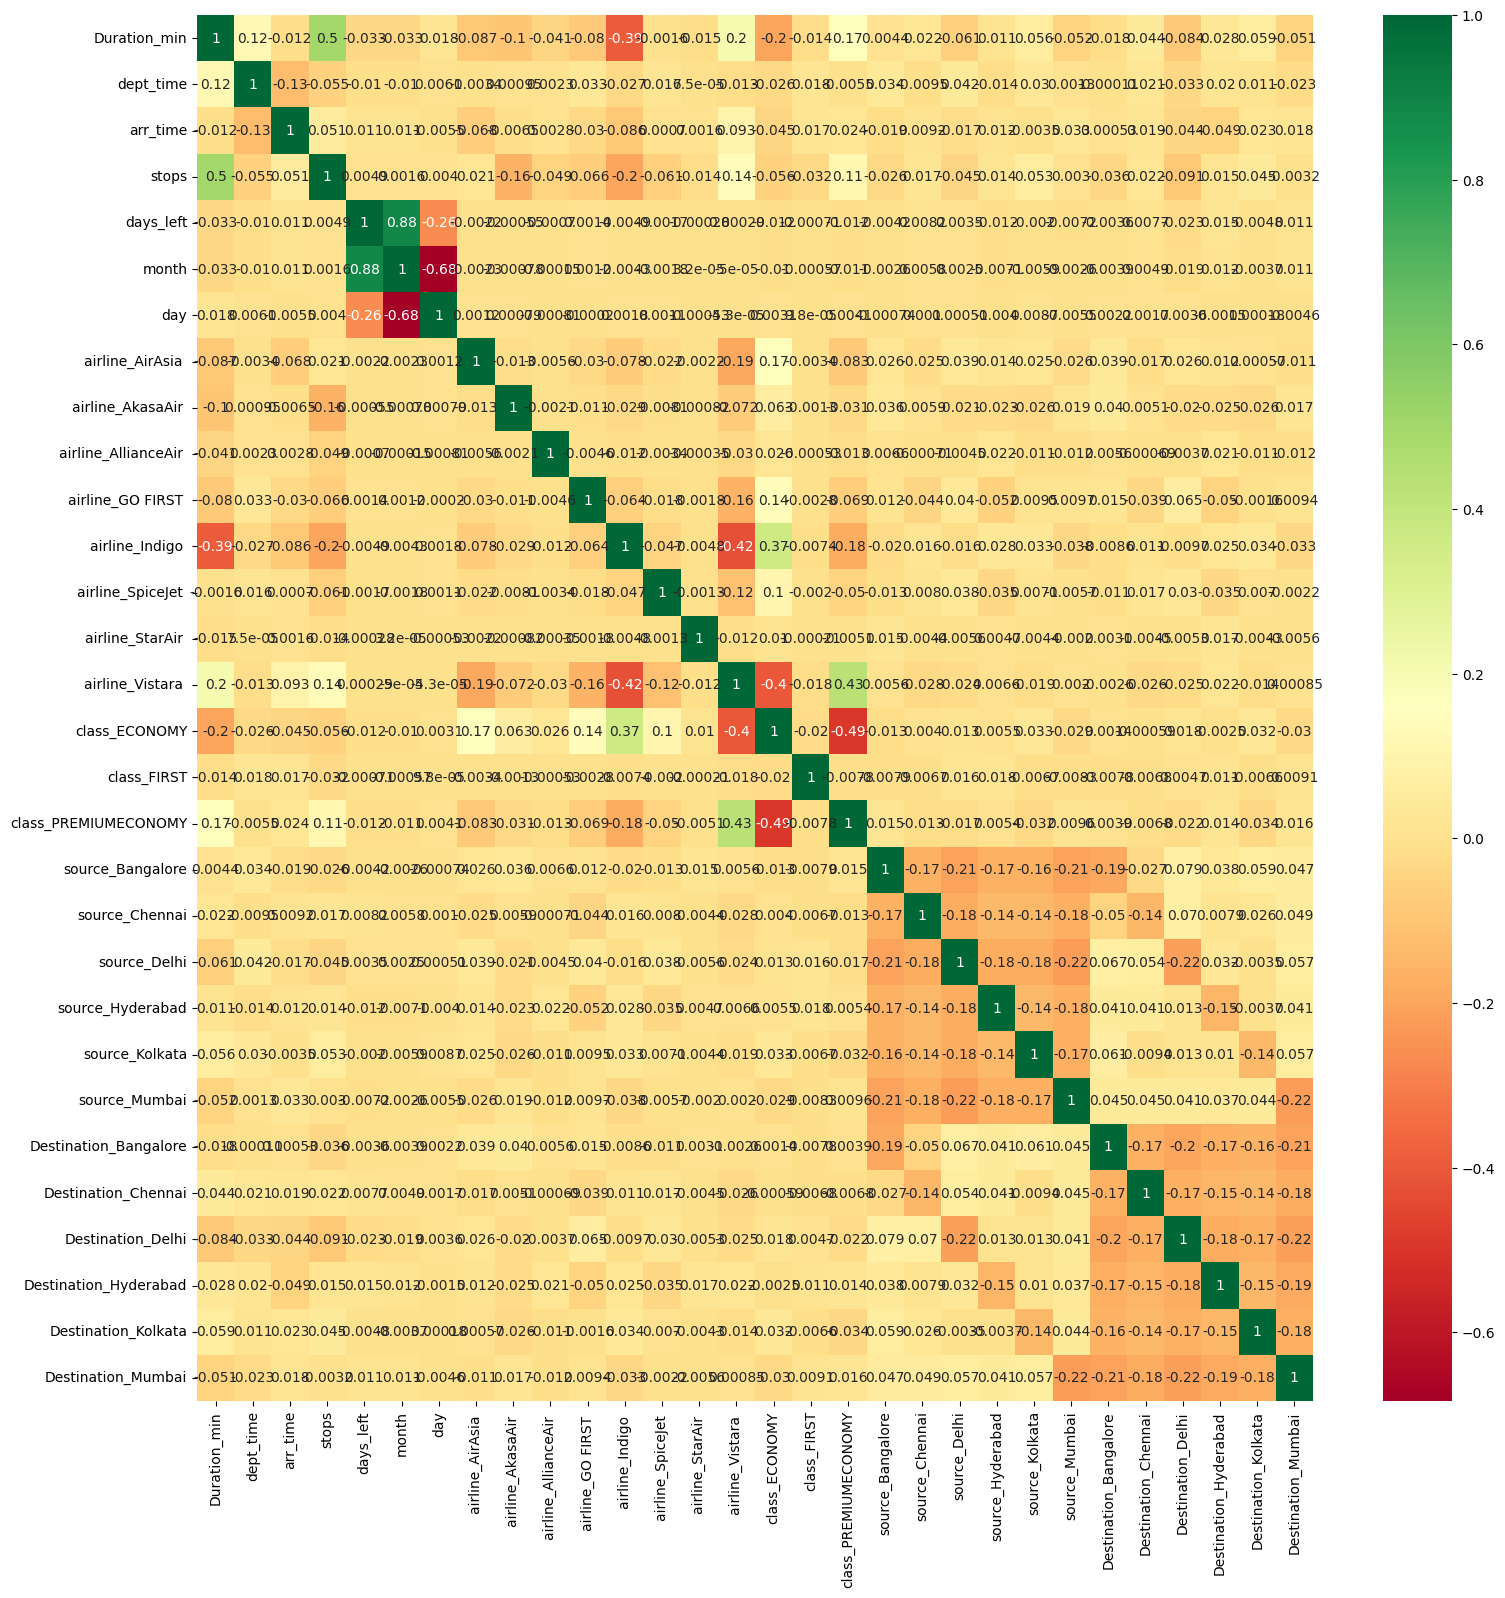

In [49]:
plt.figure(figsize = (18,18))
sns.heatmap(corr, annot = True, cmap = "RdYlGn")

plt.show()

2. Feature_importance Method

In [50]:
rfr = RandomForestRegressor()
rfr.fit(X,Y)


RandomForestRegressor()

In [51]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rfr.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(30)

,feature,importance
15,class_ECONOMY,4.876456e-01
17,class_PREMIUMECONOMY,3.113931e-01
0,Duration_min,5.993452e-02
4,days_left,3.277917e-02
2,arr_time,2.509569e-02
1,dept_time,2.151286e-02
6,day,1.153320e-02
14,airline_Vistara,1.149682e-02
22,source_Kolkata,4.055628e-03
20,source_Delhi,4.012024e-03


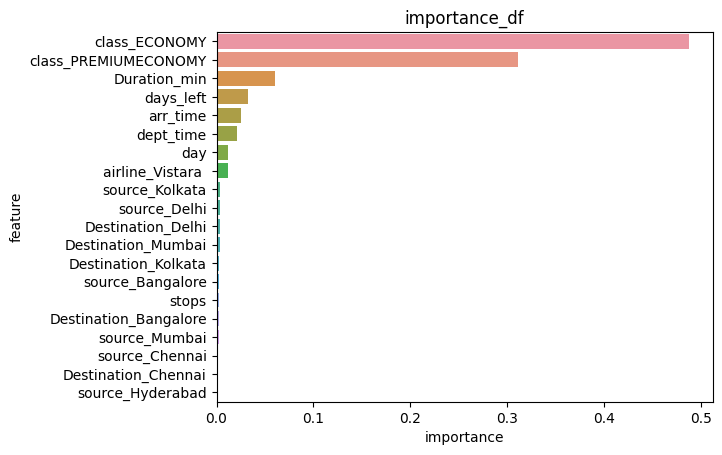

In [52]:
plt.title('importance_df')
sns.barplot(data=importance_df.head(20), x='importance', y='feature');

3. SelectKBest

In [53]:
df_new.dtypes

Duration_min             int64
dept_time                int64
arr_time                 int64
price                    int64
stops                    int64
days_left                int64
month                    int32
day                      int32
airline_AirAsia          int32
airline_AkasaAir         int32
airline_AllianceAir      int32
airline_GO FIRST         int32
airline_Indigo           int32
airline_SpiceJet         int32
airline_StarAir          int32
airline_Vistara          int32
class_ECONOMY            int32
class_FIRST              int32
class_PREMIUMECONOMY     int32
source_Bangalore         int32
source_Chennai           int32
source_Delhi             int32
source_Hyderabad         int32
source_Kolkata           int32
source_Mumbai            int32
Destination_Bangalore    int32
Destination_Chennai      int32
Destination_Delhi        int32
Destination_Hyderabad    int32
Destination_Kolkata      int32
Destination_Mumbai       int32
dtype: object

In [54]:
k_best = SelectKBest (f_regression,k=8)
k_best.fit(X,Y)
f_score = k_best.scores_
#print("{:25} {:15}".format("Feature Names","Score"))
kbest_df = pd.DataFrame({
    'feature': X.columns,
    'f-value': f_score
}).sort_values('f-value', ascending=False)
kbest_df.head(10)

,feature,f-value
15,class_ECONOMY,430094.487573
11,airline_Indigo,43795.855777
14,airline_Vistara,23431.866335
0,Duration_min,15122.208141
7,airline_AirAsia,10039.857222
17,class_PREMIUMECONOMY,9228.184521
3,stops,7295.434785
10,airline_GO FIRST,5966.211694
4,days_left,3516.297588
12,airline_SpiceJet,3146.971124


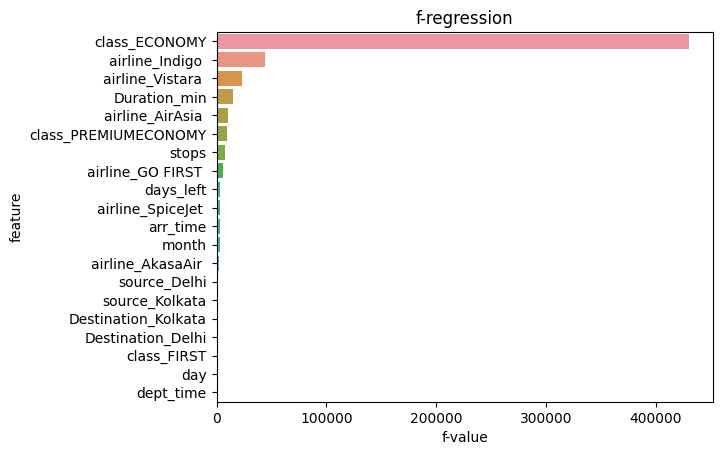

In [55]:
plt.title('f-regression')
sns.barplot(data=kbest_df.head(20), x='f-value', y='feature');

In [56]:
sc = StandardScaler()
X = sc.fit_transform(X)

Full data splited

In [57]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=7)

In [58]:
X_train.shape

(361670, 30)

creating function to calculate
1. mean_squared_error
2. mean_absolute_error
3. r2_score
for data.

In [59]:
def calculate_performance(y_train,y_pred):
    mse = mean_squared_error(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    rmse = np.sqrt(mse)

    return [rmse, mse, mae, r2]
score_names = ['RMSEs', 'MSEs', 'MAEs', 'R2s']

In [60]:
# Create objects of Regressor default hyper-parameters
model_dict={'modeldtr' :DTR,
'modelXGR' : xgb.XGBRegressor,
'modelETR' : ExtraTreesRegressor,
'modelRE':Ridge,
'modelKNN' : KNeighborsRegressor,
'modelADB' : AdaBoostRegressor,
'modelCATB' : CatBoostRegressor,
'modelLS' : Lasso,
'modelRFR' : RandomForestRegressor,
'modelGBR' : GradientBoostingRegressor,}



In [61]:
# MM = [modelmlg, modeldtr, modelETR, modelXGR, modelRE, modelKNN, modelADB,
# modelCATB, modelLS, modelRFR, modelGBR] use xgboost,catboost,knn,dtr,etr
a={'Model Name':[], 'MAE':[] ,'RMSE':[] ,'MSE':[] ,'R2_score':[]}
Results=pd.DataFrame(a)
for key in model_dict.keys():

    models = model_dict[key]()
    if key == "modelCATB":
      models = model_dict[key](verbose=0)
    # Fit the model with train data
    print(sys.getsizeof(models.fit(X_train, Y_train)))

    y_pred = models.predict(X_test)
    print(sys.getsizeof(y_pred))
    r_squared = round(r2_score(Y_test, y_pred),6)

    new_row = {'Model Name' : models,
               'MAE' :mean_absolute_error(Y_test, y_pred),
               'RMSE' : np.sqrt(mean_squared_error(Y_test, y_pred)),
               'MSE' : mean_squared_error(Y_test, y_pred),
               'R2_score' : r2_score(Y_test, y_pred)}
    new_row_df = pd.DataFrame([new_row])
    Results = pd.concat([Results,new_row_df], ignore_index=True)
    gc.collect()
    del y_pred
    



48
112
48
112
48
723456
48
723456
48
112
48
723456
48
723456


c:\Users\rvcha\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.216e+12, tolerance: 1.493e+10
  model = cd_fast.enet_coordinate_descent(


48
723456
48
723456
48
112


In [62]:
Results

,Model Name,MAE,RMSE,MSE,R2_score
0,DecisionTreeRegressor(),2071.542523,5013.334477,2.513352e+07,0.938891
1,"XGBRegressor(base_score=None, booster=None, ca...",2879.218881,4881.611636,2.383013e+07,0.942060
2,"(ExtraTreeRegressor(random_state=904880090), E...",1786.659067,3878.496342,1.504273e+07,0.963425
3,Ridge(),5101.612370,7822.320065,6.118869e+07,0.851226
4,KNeighborsRegressor(),2746.580964,5217.745456,2.722487e+07,0.933806
5,"(DecisionTreeRegressor(max_depth=3, random_sta...",6172.768810,8851.668996,7.835204e+07,0.809495
6,<catboost.core.CatBoostRegressor object at 0x0...,2882.107487,4888.292307,2.389540e+07,0.941901
7,Lasso(),5101.314525,7823.943703,6.121410e+07,0.851164
8,"(DecisionTreeRegressor(max_features=1.0, rando...",1815.782964,3774.833821,1.424937e+07,0.965354
9,([DecisionTreeRegressor(criterion='friedman_ms...,4092.864831,6596.161195,4.350934e+07,0.894212


HYPERPARAMETER TUNNING USING
  1. Random

In [63]:
selected_model = RandomForestRegressor()
param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}


GridSearchCV

In [64]:
grid_search = GridSearchCV(
    estimator=selected_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

grid_search.fit(X_train, Y_train)
print("best parameters y grid_search",grid_search.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


best parameters y grid_search {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [92]:
compare_result=pd.DataFrame(a)

In [94]:
rfr_grid = RandomForestRegressor(bootstrap= False,max_depth= 10, max_features ='sqrt', min_samples_leaf= 2,min_samples_split= 5,n_estimators=50)
rfr_grid.fit(X_train, Y_train)

y_pred = rfr_grid.predict(X_test)
new_row = {'Model Name' : models,
               'MAE' :mean_absolute_error(Y_test, y_pred),
               'RMSE' : np.sqrt(mean_squared_error(Y_test, y_pred)),
               'MSE' : mean_squared_error(Y_test, y_pred),
               'R2_score' : r2_score(Y_test, y_pred)}
new_row_df = pd.DataFrame([new_row])
compare_result = pd.concat([compare_result,new_row_df], ignore_index=True)
# print('MAE:',mean_absolute_error(Y_test, y_pred))
# print('RMSE:', np.sqrt(mean_squared_error(Y_test, y_pred)))
# print('MSE:', mean_squared_error(Y_test, y_pred))
# print("r2_score:",r2_score(Y_test, y_pred))

BayesSearchCV

In [66]:
bayes_search = BayesSearchCV(
    estimator=selected_model,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_iter=15,  # Number of Bayesian optimization steps
    random_state=7
)

bayes_search.fit(X_train, Y_train)
print("best parameters by Bayes_search",bayes_search.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\rvcha\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\rvcha\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
best parameters by Bayes_search OrderedDict([('bootstrap', False), ('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 4), ('n_estimators', 50)])


HalvingGridSearchCV

In [95]:
rfr_bo = RandomForestRegressor(bootstrap= False,max_depth= 10, max_features ='sqrt', min_samples_leaf= 2,min_samples_split= 4,n_estimators=50)
rfr_bo.fit(X_train, Y_train)

y_pred = rfr_bo.predict(X_test)
new_row = {'Model Name' : models,
               'MAE' :mean_absolute_error(Y_test, y_pred),
               'RMSE' : np.sqrt(mean_squared_error(Y_test, y_pred)),
               'MSE' : mean_squared_error(Y_test, y_pred),
               'R2_score' : r2_score(Y_test, y_pred)}
new_row_df = pd.DataFrame([new_row])
compare_result = pd.concat([compare_result,new_row_df], ignore_index=True)
# print('MAE:',mean_absolute_error(Y_test, y_pred))
# print('RMSE:', np.sqrt(mean_squared_error(Y_test, y_pred)))
# print('MSE:', mean_squared_error(Y_test, y_pred))
# print("r2_score:",r2_score(Y_test, y_pred))

In [68]:
hgr = HalvingGridSearchCV(
    estimator=selected_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
)

hgr.fit(X_train, Y_train)
print("best parameters by halvinggridsearch",hgr.best_params_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 40185
max_resources_: 361670
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 16
n_resources: 40185
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 6
n_resources: 120555
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 361665
Fitting 5 folds for each of 2 candidates, totalling 10 fits
best parameters by halvinggridsearch {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [96]:
rfr_hgr = RandomForestRegressor(bootstrap= False,max_depth= 10, max_features ='sqrt', min_samples_leaf= 2,min_samples_split= 2,n_estimators=50)
rfr_hgr.fit(X_train, Y_train)

y_pred = rfr_hgr.predict(X_test)
new_row = {'Model Name' : models,
               'MAE' :mean_absolute_error(Y_test, y_pred),
               'RMSE' : np.sqrt(mean_squared_error(Y_test, y_pred)),
               'MSE' : mean_squared_error(Y_test, y_pred),
               'R2_score' : r2_score(Y_test, y_pred)}
new_row_df = pd.DataFrame([new_row])
compare_result = pd.concat([compare_result,new_row_df], ignore_index=True)
# print('MAE:',mean_absolute_error(Y_test, y_pred))
# print('RMSE:', np.sqrt(mean_squared_error(Y_test, y_pred)))
# print('MSE:', mean_squared_error(Y_test, y_pred))
# print("r2_score:",r2_score(Y_test, y_pred))

In [70]:
random_search = RandomizedSearchCV(
    estimator=selected_model,
    param_distributions=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_iter=100,  # Number of random combinations to try
    random_state=7
)

random_search.fit(X_train, Y_train)
print("best parameters by random search",random_search.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\rvcha\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


best parameters by random search {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [90]:
rfr_rs = RandomForestRegressor(bootstrap= True,max_depth= 10, max_features ='sqrt', min_samples_leaf= 1,min_samples_split= 2,n_estimators=50)
rfr_rs.fit(X_train, Y_train)

y_pred = rfr_rs.predict(X_test)
new_row = {'Model Name' : models,
               'MAE' :mean_absolute_error(Y_test, y_pred),
               'RMSE' : np.sqrt(mean_squared_error(Y_test, y_pred)),
               'MSE' : mean_squared_error(Y_test, y_pred),
               'R2_score' : r2_score(Y_test, y_pred)}
new_row_df = pd.DataFrame([new_row])
compare_result = pd.concat([compare_result,new_row_df], ignore_index=True)
# print('MAE:',mean_absolute_error(Y_test, y_pred))
# print('RMSE:', np.sqrt(mean_squared_error(Y_test, y_pred)))
# print('MSE:', mean_squared_error(Y_test, y_pred))
# print("r2_score:",r2_score(Y_test, y_pred))


MAE: 5287.511772318568
RMSE: 8015.681290159416
MSE: 64251146.54541172
r2_score: 0.8437802328185814


storing model in pickel file

In [97]:
import pickle
with open('flight.pkl', 'wb') as file:
    pickle.dump(rfr_bo, file)

# Load the trained model using pickle
with open('flight.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

forest = pickle.load(model)
y_prediction = forest.predict(X_test)
r2_score(Y_test, y_prediction)

In [98]:
loaded_model

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=4, n_estimators=50)

In [ ]:
# #airline,clas,source,Destination,Duration_min,dept_time,arr_time,Total_stops,days_left,month,day
# # new_instance = {
# #     'airline':0,
# #     'class': 0,
# #     'source':3,
# #     'Destination':6,
# #     'Duration_min': 135,
# #     'dept_time':1350,
# #     'arr_time': 45,
# #     'stops': 0,
# #     'days_left':1,
# #     'month':1,
# #     'day':16
    
# # }

# feature_vector = [[
#     140,1380,80,0,1,1,16,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
# ]]

# feature_vector = np.array(feature_vector).reshape(1, -1)

# # Predict the flight price using the trained model
# predicted_price = etr.predict(feature_vector)[0]

# print("Predicted Price:", predicted_price)

Predicted Price: 23126.57
